In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import copy
import numpy as np


import pickle

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
train_dataloaderF = DataLoader(training_data, batch_size=256,shuffle=True)
train_dataloaderH = DataLoader(training_data, batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def tt_loop(K,lrs,a, model, loss_fn,epochs):

    Res = {"train_loss":[],"test_loss":[],"test_acc":[]}
    for t in range(epochs):
         print(f"Epoch {t+1}\n-------------------------------")
         size = len(train_dataloaderF.dataset)
         m_f = [None for _ in model.parameters()]
         dloadH = iter(train_dataloaderH)
         for batch, (X, y) in enumerate(train_dataloaderF):
             lr = lrs[t*len(train_dataloaderF) + batch]
             backup = copy.deepcopy(model).to(device)
             X, y = X.to(device), y.to(device)
             pred = model(X)
             loss = loss_fn(pred, y)
             model.zero_grad()
             loss.backward()
             with torch.no_grad():
                for i,p in enumerate(model.parameters()):
                    m_f[i] = p.grad if batch==0 else (1-a)*m_f[i] + a*p.grad

        
             try:
               (X, y) = next(dloadH)
             except StopIteration:
               dloadH = iter(train_dataloaderH)
               (X, y) = next(dloadH)
             X, y = X.to(device), y.to(device)
             for k in range(K):
                 # Compute prediction and loss
                 pred = backup(X)
                 loss = loss_fn(pred, y)

                 # Backpropagation
                 backup.zero_grad()
                 loss.backward()

                 grad_hx = [None for _ in backup.parameters()]
                 with torch.no_grad():
                     for i,param in enumerate(backup.parameters()):
                           grad_hx[i] = param.grad


                 pred = model(X)
                 loss = loss_fn(pred, y)

                 # Backpropagation
                 model.zero_grad()
                 loss.backward()

                 grad_hy = [None for _ in model.parameters()]
                 with torch.no_grad():
                     for i,param in enumerate(model.parameters()):
                         grad_hy[i] = param.grad

                 with torch.no_grad():
                     for i,param in enumerate(model.parameters()):
                        param -= lr * (grad_hy[i] - grad_hx[i] + m_f[i])
             if batch % 50 == 0:
                 loss, current = loss.item(), batch * len(X)
                 # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                 Res["train_loss"].append(loss)
                 #test
                 size = len(test_dataloader.dataset)
                 num_batches = len(test_dataloader)
                 test_loss, correct = 0, 0

                 with torch.no_grad():
                    for X, y in test_dataloader:
                        pred = model(X)
                        test_loss += loss_fn(pred, y).item()
                        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

                 test_loss /= num_batches
                 correct /= size
                 Res["test_loss"].append(test_loss)
                 Res["test_acc"].append(correct)
                    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return Res
            

In [ ]:
Ks = [1,5,10] 
epochs = 10
T = np.arange(len(train_dataloaderF)*epochs) + 1
lrs = 1e-1 / np.sqrt(T)
a = 0.1
Res = {}
for K in Ks:
  print("K=",K)
  model = NeuralNetwork().to(device)
  Res[K] = tt_loop(K,lrs,a, model, loss_fn,epochs)

with open('FashionMnistExp.pkl', 'wb') as f:
    pickle.dump(Res, f)

K= 1
Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
K= 5
Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
K= 10
Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
--------------

In [ ]:
import pickle

import matplotlib.pyplot as plt


In [ ]:
with open('FashionMnistExp.pkl', 'rb') as f:
    Res = pickle.load(f)

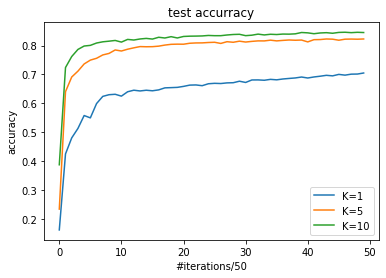

In [ ]:
for k in Res:
  plt.plot(Res[k]["test_acc"],label="K="+str(k))

plt.title("test accurracy")
plt.xlabel("#iterations/50")
plt.ylabel("accuracy")
plt.legend()
plt.savefig("images/FashionMnistExp4TestAccuracy")

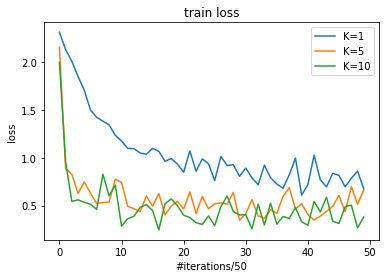

In [ ]:
for k in Res:
  plt.plot(Res[k]["train_loss"],label="K="+str(k))

plt.title("train loss")
plt.xlabel("#iterations/50")
plt.ylabel("loss")
plt.legend()
plt.savefig("images/FashionMnistExp4TrainLoss")
